# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.368754
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *the loss is log probability of the correct class label. Since we have 10 class, the probability must be around 1/10 for W is randomly initialized. Since log is slowly changing function so the loss is around -log(1/10)*


In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.408257 analytic: 0.408256, relative error: 1.065769e-07
numerical: -0.278528 analytic: -0.278528, relative error: 1.162753e-07
numerical: 1.014212 analytic: 1.014212, relative error: 1.565817e-09
numerical: 1.008586 analytic: 1.008586, relative error: 1.612486e-08
numerical: 0.509376 analytic: 0.509376, relative error: 6.495213e-08
numerical: 0.831566 analytic: 0.831565, relative error: 6.815066e-08
numerical: -1.090255 analytic: -1.090255, relative error: 3.008624e-08
numerical: 2.289766 analytic: 2.289766, relative error: 2.862730e-08
numerical: 0.078289 analytic: 0.078289, relative error: 2.841160e-07
numerical: -4.929618 analytic: -4.929618, relative error: 4.407739e-09
numerical: -2.998388 analytic: -2.998388, relative error: 8.639810e-09
numerical: -0.480655 analytic: -0.480655, relative error: 6.867758e-09
numerical: -1.044975 analytic: -1.044975, relative error: 8.907313e-09
numerical: -0.508430 analytic: -0.508430, relative error: 5.697562e-08
numerical: 1.208598 

In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))
print('naive gradient:  computed in ' , grad_naive.shape)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))
print('gradient loss:  computed in' , grad_vectorized.shape)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.368754e+00 computed in 0.090307s
naive gradient:  computed in  (3073, 10)
vectorized loss: 2.368754e+00 computed in 0.007855s
gradient loss:  computed in (3073, 10)
Loss difference: 0.000000
Gradient difference: 0.000000


In [28]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [0.8e-7, 1.6e-7]
regularization_strengths = [0.1e4, 1.28e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

 #run a random search for best hyperparameters
num_trial  = 80
    
for i in range(num_trial):
    learning_rate = (learning_rates[1] - learning_rates[0]) * np.random.random_sample() + learning_rates[0]
    reg = (regularization_strengths[1] - regularization_strengths[0]) * np.random.random_sample() + regularization_strengths[0]
    print('### Experiment ', i, ': Learning rate, %e' 
                              %learning_rate, ', Regularization Strength, %f'%reg, ' ###')

    softmax = Softmax()
    lost_hist = softmax.train(X_train, y_train, learning_rate, reg,
                  num_iters=1500, verbose=True)

    y_train_pred = softmax.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = softmax.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)

    results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)

    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)



### Experiment  0 : Learning rate, 1.066999e-07 , Regularization Strength, 5084.876262  ###
iteration 0 / 1500: loss 161.273258
iteration 100 / 1500: loss 128.905555
iteration 200 / 1500: loss 103.624812
iteration 300 / 1500: loss 83.548744
iteration 400 / 1500: loss 67.659557
iteration 500 / 1500: loss 54.703615
iteration 600 / 1500: loss 44.214559
iteration 700 / 1500: loss 35.971718
iteration 800 / 1500: loss 29.010503
iteration 900 / 1500: loss 23.854013
iteration 1000 / 1500: loss 19.530444
iteration 1100 / 1500: loss 16.051947
iteration 1200 / 1500: loss 13.288062
iteration 1300 / 1500: loss 11.048292
iteration 1400 / 1500: loss 9.217311
### Experiment  1 : Learning rate, 1.392038e-07 , Regularization Strength, 6710.059566  ###
iteration 0 / 1500: loss 210.134954
iteration 100 / 1500: loss 143.557466
iteration 200 / 1500: loss 99.002277
iteration 300 / 1500: loss 68.491108
iteration 400 / 1500: loss 47.486881
iteration 500 / 1500: loss 33.347793
iteration 600 / 1500: loss 23.4645

iteration 900 / 1500: loss 35.691127
iteration 1000 / 1500: loss 30.324898
iteration 1100 / 1500: loss 25.944700
iteration 1200 / 1500: loss 22.067999
iteration 1300 / 1500: loss 18.909443
iteration 1400 / 1500: loss 16.166508
### Experiment  13 : Learning rate, 1.543285e-07 , Regularization Strength, 1207.362438  ###
iteration 0 / 1500: loss 41.486363
iteration 100 / 1500: loss 37.411695
iteration 200 / 1500: loss 34.310916
iteration 300 / 1500: loss 31.819249
iteration 400 / 1500: loss 29.482415
iteration 500 / 1500: loss 27.676236
iteration 600 / 1500: loss 25.485717
iteration 700 / 1500: loss 23.715906
iteration 800 / 1500: loss 22.082727
iteration 900 / 1500: loss 20.725382
iteration 1000 / 1500: loss 19.194631
iteration 1100 / 1500: loss 17.944909
iteration 1200 / 1500: loss 16.745148
iteration 1300 / 1500: loss 15.629991
iteration 1400 / 1500: loss 14.622780
### Experiment  14 : Learning rate, 1.027970e-07 , Regularization Strength, 4349.116539  ###
iteration 0 / 1500: loss 138.

iteration 300 / 1500: loss 67.924826
iteration 400 / 1500: loss 51.866364
iteration 500 / 1500: loss 39.884796
iteration 600 / 1500: loss 30.720797
iteration 700 / 1500: loss 23.897195
iteration 800 / 1500: loss 18.670409
iteration 900 / 1500: loss 14.639464
iteration 1000 / 1500: loss 11.494941
iteration 1100 / 1500: loss 9.253562
iteration 1200 / 1500: loss 7.528624
iteration 1300 / 1500: loss 6.183959
iteration 1400 / 1500: loss 5.186440
### Experiment  26 : Learning rate, 1.476067e-07 , Regularization Strength, 11970.907440  ###
iteration 0 / 1500: loss 374.907586
iteration 100 / 1500: loss 184.421838
iteration 200 / 1500: loss 91.490915
iteration 300 / 1500: loss 46.019608
iteration 400 / 1500: loss 23.580129
iteration 500 / 1500: loss 12.697594
iteration 600 / 1500: loss 7.277200
iteration 700 / 1500: loss 4.532487
iteration 800 / 1500: loss 3.295811
iteration 900 / 1500: loss 2.615715
iteration 1000 / 1500: loss 2.270060
iteration 1100 / 1500: loss 2.225738
iteration 1200 / 1500

iteration 1400 / 1500: loss 2.126271
### Experiment  38 : Learning rate, 8.726504e-08 , Regularization Strength, 6594.616108  ###
iteration 0 / 1500: loss 206.450790
iteration 100 / 1500: loss 163.225158
iteration 200 / 1500: loss 129.564893
iteration 300 / 1500: loss 102.901446
iteration 400 / 1500: loss 81.940258
iteration 500 / 1500: loss 65.437325
iteration 600 / 1500: loss 52.250534
iteration 700 / 1500: loss 41.782639
iteration 800 / 1500: loss 33.522972
iteration 900 / 1500: loss 27.067193
iteration 1000 / 1500: loss 21.792345
iteration 1100 / 1500: loss 17.773582
iteration 1200 / 1500: loss 14.394041
iteration 1300 / 1500: loss 11.892607
iteration 1400 / 1500: loss 9.881395
### Experiment  39 : Learning rate, 1.530888e-07 , Regularization Strength, 1904.954171  ###
iteration 0 / 1500: loss 63.863564
iteration 100 / 1500: loss 55.048302
iteration 200 / 1500: loss 48.919819
iteration 300 / 1500: loss 43.548101
iteration 400 / 1500: loss 38.838632
iteration 500 / 1500: loss 34.345

iteration 700 / 1500: loss 11.829564
iteration 800 / 1500: loss 8.013765
iteration 900 / 1500: loss 5.633021
iteration 1000 / 1500: loss 4.122877
iteration 1100 / 1500: loss 3.389193
iteration 1200 / 1500: loss 2.801431
iteration 1300 / 1500: loss 2.536088
iteration 1400 / 1500: loss 2.347041
### Experiment  51 : Learning rate, 1.263549e-07 , Regularization Strength, 2058.077931  ###
iteration 0 / 1500: loss 68.570371
iteration 100 / 1500: loss 60.298121
iteration 200 / 1500: loss 54.099032
iteration 300 / 1500: loss 48.517789
iteration 400 / 1500: loss 43.867098
iteration 500 / 1500: loss 39.786536
iteration 600 / 1500: loss 35.641304
iteration 700 / 1500: loss 32.365837
iteration 800 / 1500: loss 29.126173
iteration 900 / 1500: loss 26.431521
iteration 1000 / 1500: loss 23.837462
iteration 1100 / 1500: loss 21.722682
iteration 1200 / 1500: loss 19.783404
iteration 1300 / 1500: loss 17.911403
iteration 1400 / 1500: loss 16.244038
### Experiment  52 : Learning rate, 8.536950e-08 , Regu

iteration 100 / 1500: loss 134.899758
iteration 200 / 1500: loss 114.013953
iteration 300 / 1500: loss 96.363188
iteration 400 / 1500: loss 81.697487
iteration 500 / 1500: loss 69.263631
iteration 600 / 1500: loss 58.592801
iteration 700 / 1500: loss 49.812609
iteration 800 / 1500: loss 42.449871
iteration 900 / 1500: loss 36.164808
iteration 1000 / 1500: loss 30.743886
iteration 1100 / 1500: loss 26.366011
iteration 1200 / 1500: loss 22.407296
iteration 1300 / 1500: loss 19.365436
iteration 1400 / 1500: loss 16.617954
### Experiment  64 : Learning rate, 1.139103e-07 , Regularization Strength, 2365.018233  ###
iteration 0 / 1500: loss 78.803065
iteration 100 / 1500: loss 69.461602
iteration 200 / 1500: loss 62.097246
iteration 300 / 1500: loss 55.667583
iteration 400 / 1500: loss 49.906174
iteration 500 / 1500: loss 44.827378
iteration 600 / 1500: loss 40.368743
iteration 700 / 1500: loss 36.546407
iteration 800 / 1500: loss 32.886698
iteration 900 / 1500: loss 29.630230
iteration 1000

iteration 1200 / 1500: loss 16.384848
iteration 1300 / 1500: loss 14.324481
iteration 1400 / 1500: loss 12.566433
### Experiment  76 : Learning rate, 1.133670e-07 , Regularization Strength, 11560.467974  ###
iteration 0 / 1500: loss 359.372672
iteration 100 / 1500: loss 211.959243
iteration 200 / 1500: loss 125.965535
iteration 300 / 1500: loss 75.219116
iteration 400 / 1500: loss 45.188004
iteration 500 / 1500: loss 27.474345
iteration 600 / 1500: loss 16.994762
iteration 700 / 1500: loss 10.893772
iteration 800 / 1500: loss 7.262735
iteration 900 / 1500: loss 5.110896
iteration 1000 / 1500: loss 3.909930
iteration 1100 / 1500: loss 3.084224
iteration 1200 / 1500: loss 2.661547
iteration 1300 / 1500: loss 2.387012
iteration 1400 / 1500: loss 2.257565
### Experiment  77 : Learning rate, 1.425357e-07 , Regularization Strength, 2495.909929  ###
iteration 0 / 1500: loss 83.203332
iteration 100 / 1500: loss 70.604016
iteration 200 / 1500: loss 61.279110
iteration 300 / 1500: loss 52.876995

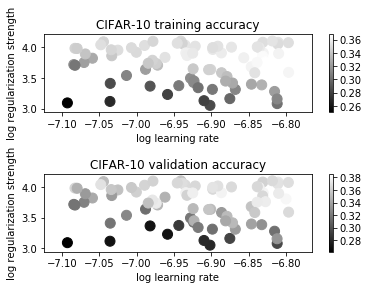

softmax on raw pixels final test set accuracy: 0.375000


In [31]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.subplots_adjust(wspace=1.6,hspace=0.8)
plt.show()

# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

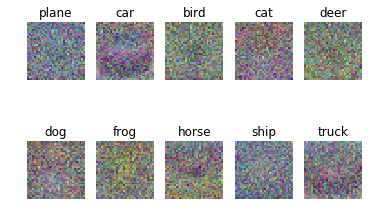

In [32]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])